### Import Relevant Libraries

In [1]:
import numpy as np 
import pandas as pd 
import datetime as datetime
import scipy.stats as stats
from scipy.interpolate import make_interp_spline, BSpline
import h3

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn")
import seaborn as sns

### Ingest data from CSV file

In [2]:
data = pd.read_csv('2013-10 - Citi Bike trip data.csv')
data.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,326,2013-10-01 00:01:08,2013-10-01 00:06:34,239,Willoughby St & Fleet St,40.691966,-73.981302,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,16052,Subscriber,1982,1
1,729,2013-10-01 00:01:21,2013-10-01 00:13:30,322,Clinton St & Tillary St,40.696192,-73.991218,398,Atlantic Ave & Furman St,40.691652,-73.999979,19412,Customer,\N,0
2,520,2013-10-01 00:01:24,2013-10-01 00:10:04,174,E 25 St & 1 Ave,40.738177,-73.977387,403,E 2 St & 2 Ave,40.725029,-73.990697,19645,Subscriber,1984,1
3,281,2013-10-01 00:01:25,2013-10-01 00:06:06,430,York St & Jay St,40.701485,-73.986569,323,Lawrence St & Willoughby St,40.692362,-73.986317,16992,Subscriber,1985,1
4,196,2013-10-01 00:01:27,2013-10-01 00:04:43,403,E 2 St & 2 Ave,40.725029,-73.990697,401,Allen St & Rivington St,40.720196,-73.989978,15690,Subscriber,1986,1


### Understand the data set

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037712 entries, 0 to 1037711
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   tripduration             1037712 non-null  int64  
 1   starttime                1037712 non-null  object 
 2   stoptime                 1037712 non-null  object 
 3   start station id         1037712 non-null  int64  
 4   start station name       1037712 non-null  object 
 5   start station latitude   1037712 non-null  float64
 6   start station longitude  1037712 non-null  float64
 7   end station id           1037712 non-null  int64  
 8   end station name         1037712 non-null  object 
 9   end station latitude     1037712 non-null  float64
 10  end station longitude    1037712 non-null  float64
 11  bikeid                   1037712 non-null  int64  
 12  usertype                 1037712 non-null  object 
 13  birth year               1037712 non-null 

In [4]:
# convert startiime and stoptime from objects to datetime values
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037712 entries, 0 to 1037711
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   tripduration             1037712 non-null  int64         
 1   starttime                1037712 non-null  datetime64[ns]
 2   stoptime                 1037712 non-null  datetime64[ns]
 3   start station id         1037712 non-null  int64         
 4   start station name       1037712 non-null  object        
 5   start station latitude   1037712 non-null  float64       
 6   start station longitude  1037712 non-null  float64       
 7   end station id           1037712 non-null  int64         
 8   end station name         1037712 non-null  object        
 9   end station latitude     1037712 non-null  float64       
 10  end station longitude    1037712 non-null  float64       
 11  bikeid                   1037712 non-null  int64         
 12  

In [5]:
# check oldest and latest dates in dataframe to understand dataset timeframe
print('earliest date: ', data['starttime'].min(), '\nlatest date: ', data['starttime'].max())

earliest date:  2013-10-01 00:01:08 
latest date:  2013-10-31 23:59:57


In [6]:
data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,gender
count,1.037712e+06,1.037712e+06,1.037712e+06,1.037712e+06,1.037712e+06,1.037712e+06,1.037712e+06,1.037712e+06,1.037712e+06
mean,8.256148e+02,4.437142e+02,4.073452e+01,-7.399113e+01,4.432074e+02,4.073428e+01,-7.399127e+01,1.764407e+04,1.123756e+00
std,2.000373e+03,3.544343e+02,1.957341e-02,1.231612e-02,3.573982e+02,1.955785e-02,1.238558e-02,1.717681e+03,5.443806e-01
min,6.000000e+01,7.200000e+01,4.068034e+01,-7.401713e+01,7.200000e+01,4.068034e+01,-7.401713e+01,1.452900e+04,0.000000e+00
25%,3.940000e+02,3.030000e+02,4.072165e+01,-7.400017e+01,3.010000e+02,4.072087e+01,-7.400027e+01,1.616400e+04,1.000000e+00
50%,6.220000e+02,4.020000e+02,4.073620e+01,-7.399076e+01,4.020000e+02,4.073544e+01,-7.399099e+01,1.765800e+04,1.000000e+00
75%,1.005000e+03,4.860000e+02,4.075020e+01,-7.398205e+01,4.850000e+02,4.074972e+01,-7.398263e+01,1.911300e+04,1.000000e+00
max,1.259480e+06,3.002000e+03,4.077051e+01,-7.395005e+01,3.002000e+03,4.077051e+01,-7.395005e+01,2.075700e+04,2.000000e+00


### Charts and Analysis

#### Analysis for total trip hits per station

In [7]:
# count total number of trips started and ended at each station
starttrips = data[['start station name','bikeid']].groupby('start station name',).count().reset_index()
endtrips = data[['end station name','bikeid']].groupby('end station name',).count().reset_index()

starttrips.rename(columns={'start station name':'station', 'bikeid':'starttrips'}, inplace=True)
endtrips.rename(columns={'end station name':'station', 'bikeid':'endtrips'}, inplace=True)

In [8]:
# calculate total trip hits at each station
triphits = pd.merge(starttrips,endtrips,on='station')
triphits['total trip hits'] = triphits['starttrips'] + triphits['endtrips']
triphits

,station,starttrips,endtrips,total trip hits
0,1 Ave & E 15 St,5239,5449,10688
1,1 Ave & E 18 St,3481,3740,7221
2,1 Ave & E 30 St,4327,4384,8711
3,1 Ave & E 44 St,2316,2467,4783
4,10 Ave & W 28 St,3028,3168,6196
...,...,...,...,...
325,Willoughby Ave & Hall St,976,941,1917
326,Willoughby Ave & Walworth St,632,681,1313
327,Willoughby St & Fleet St,1126,1099,2225
328,Wythe Ave & Metropolitan Ave,1670,1807,3477


In [9]:
busieststations = triphits.nlargest(10, 'total trip hits')
busieststations.sort_values('total trip hits', inplace=True)

#### Bar Chart

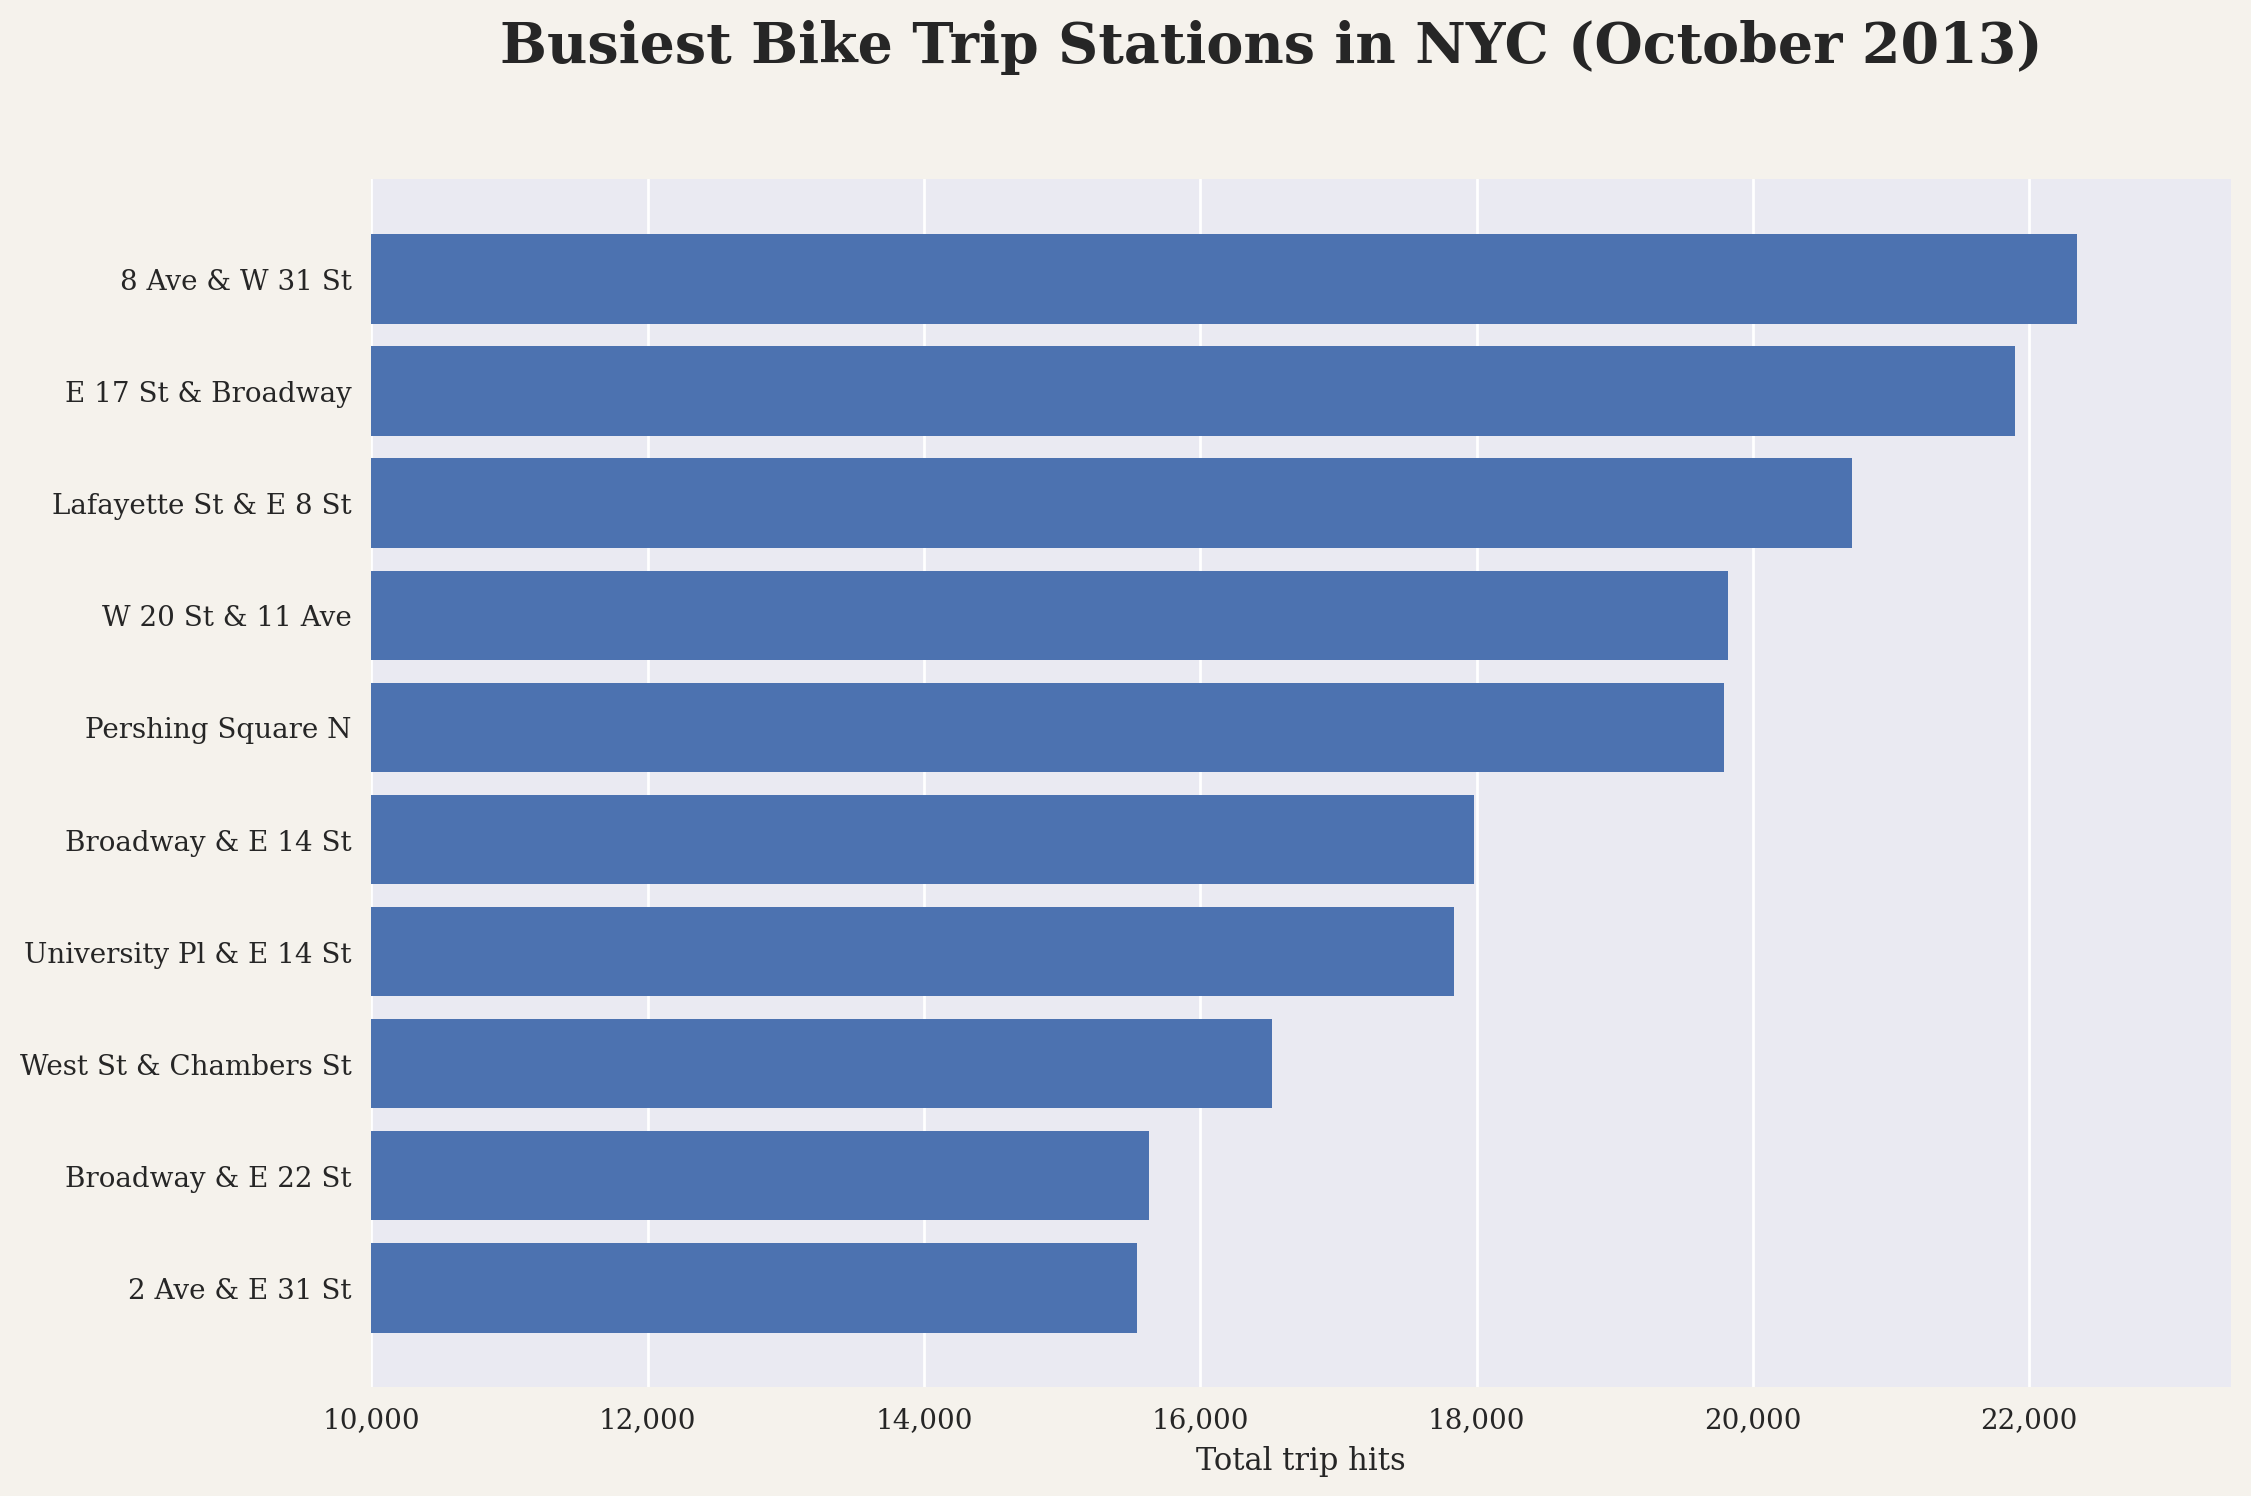

In [10]:
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes()

ax.barh(busieststations['station']
       , busieststations['total trip hits']
       , label = 'Total trip hits')

fig.suptitle("Busiest Bike Trip Stations in NYC (October 2013)", fontsize=20, fontfamily='serif', weight='bold')
fig.set_facecolor('#f5f2ec')

ax.yaxis.grid(None)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:0,.0f}'))
ax.set_xlabel('Total trip hits', fontfamily='Serif')
plt.yticks(fontname = 'Serif')
plt.xticks(fontname = 'Serif')
ax.set_xlim(10000)


plt.show()

#### Histogram Chart

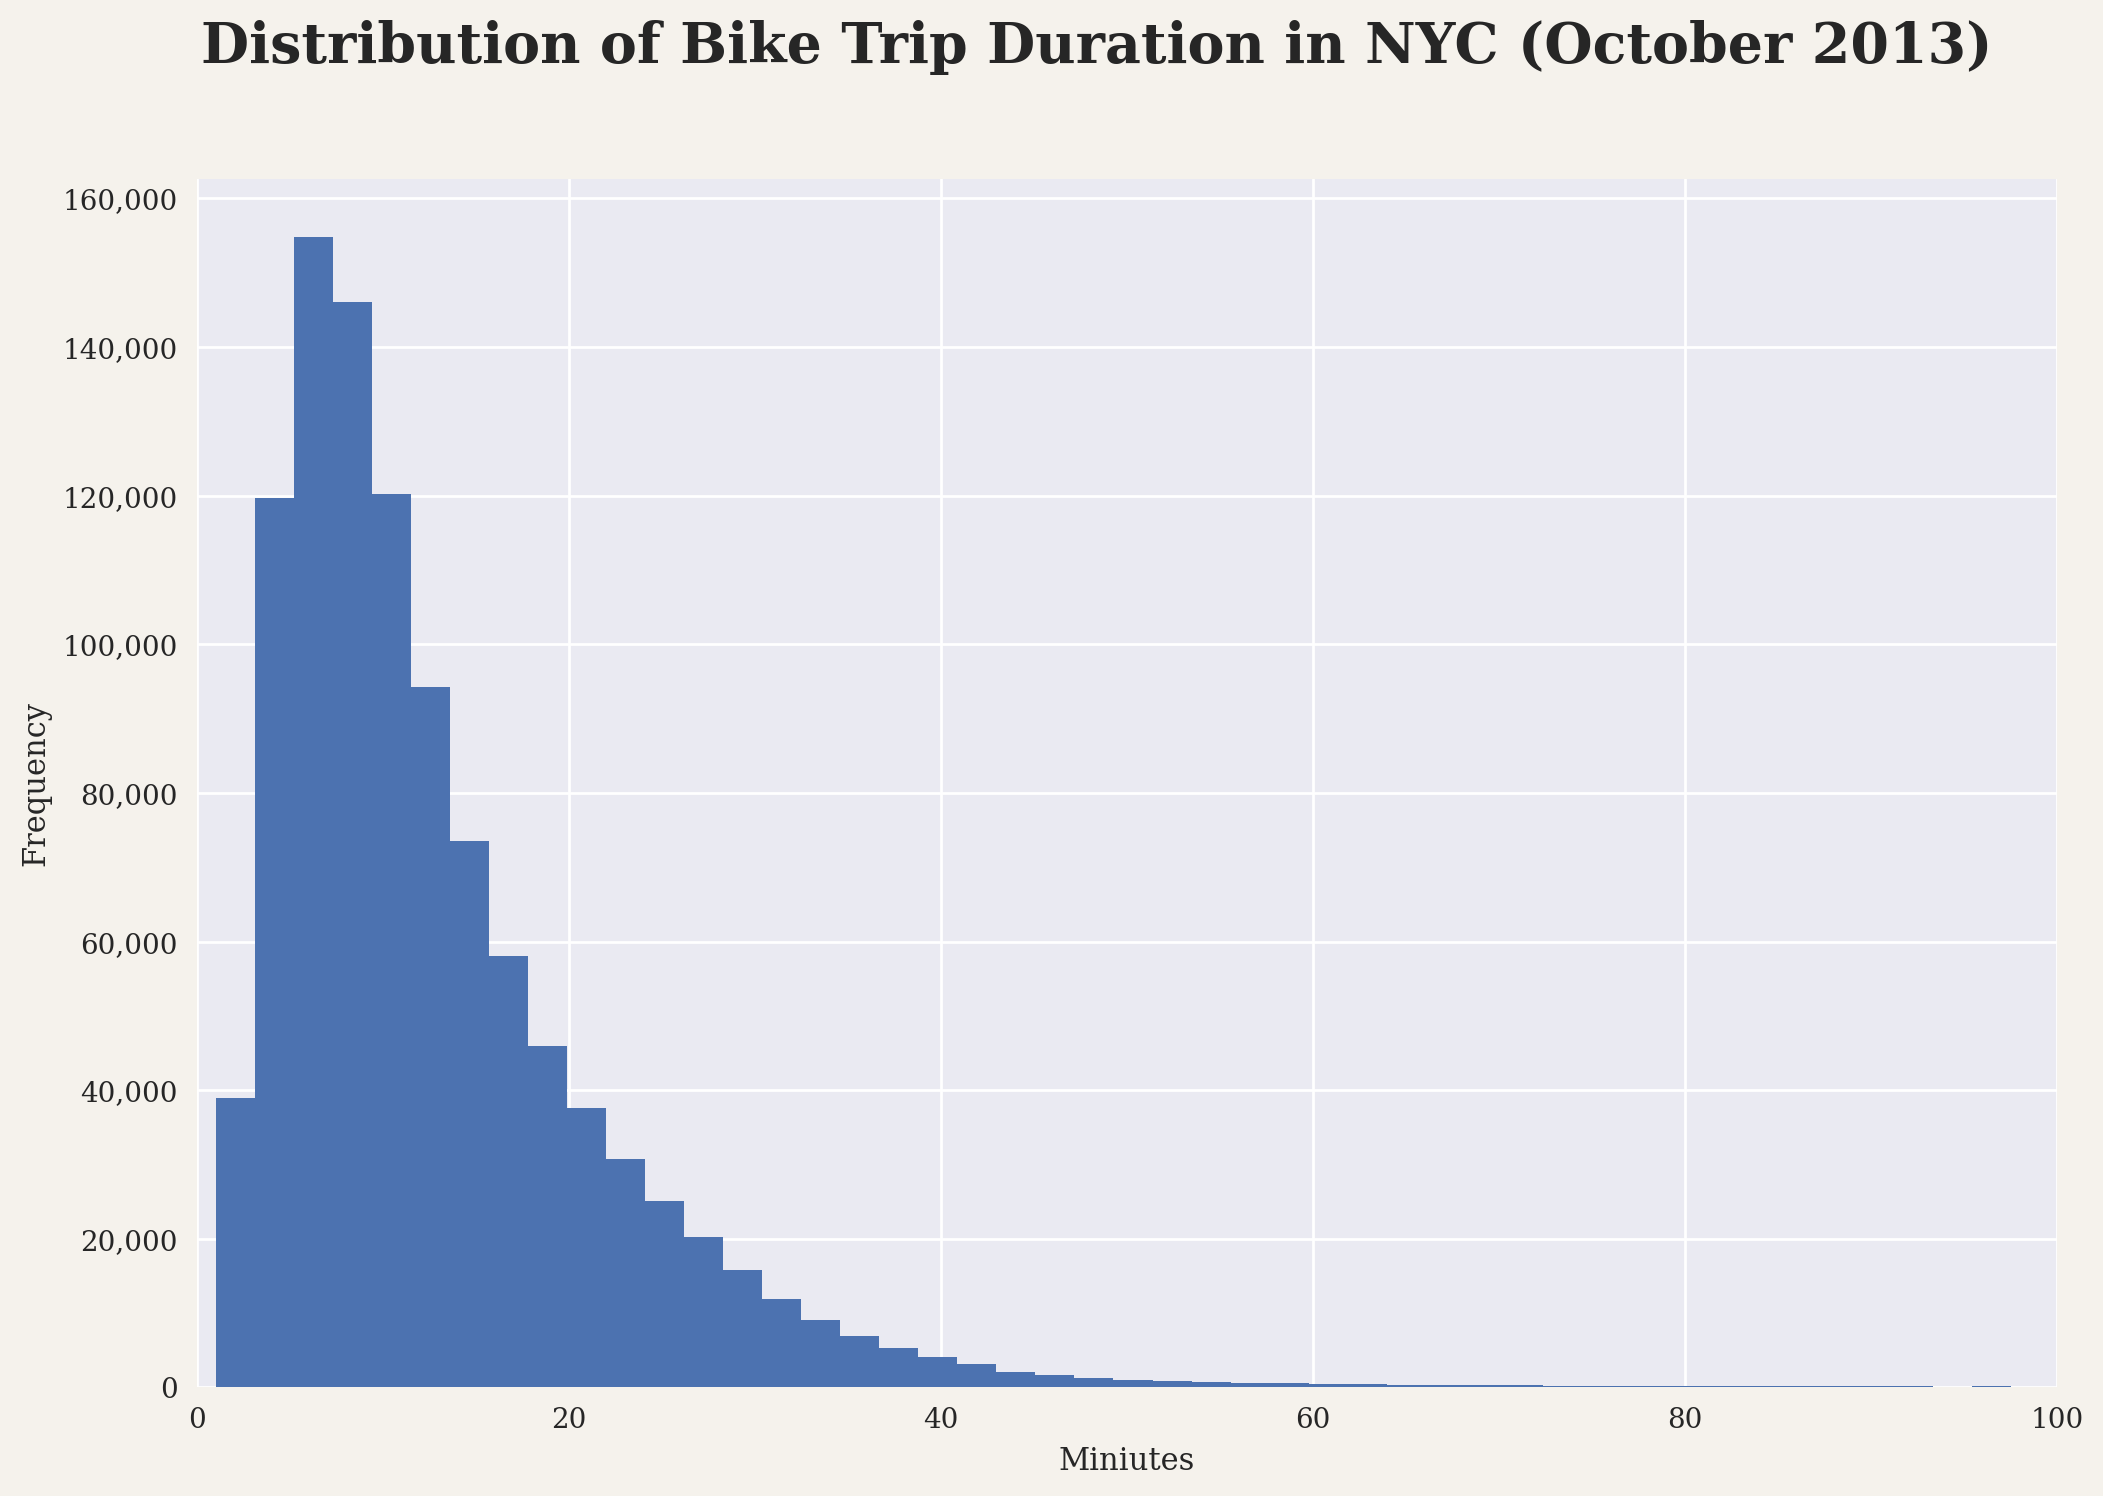

In [11]:
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes()

ax.hist(data['tripduration']/60,bins=10000)

fig.suptitle("Distribution of Bike Trip Duration in NYC (October 2013)", fontsize=20, fontfamily='serif', weight='bold')
fig.set_facecolor('#f5f2ec')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:0,.0f}'))
ax.set_xlabel('Miniutes', fontfamily = 'Serif')
ax.set_xlim(0,100)
ax.set_ylabel('Frequency', fontfamily = 'Serif')
plt.yticks(fontname = 'Serif')
plt.xticks(fontname = 'Serif')

plt.show()

#### Analysis of proportion of trips by gender

In [12]:
# count total number of trips by gender
genderdata = data[['gender','bikeid']].groupby('gender').count().reset_index()

#### Pie Chart

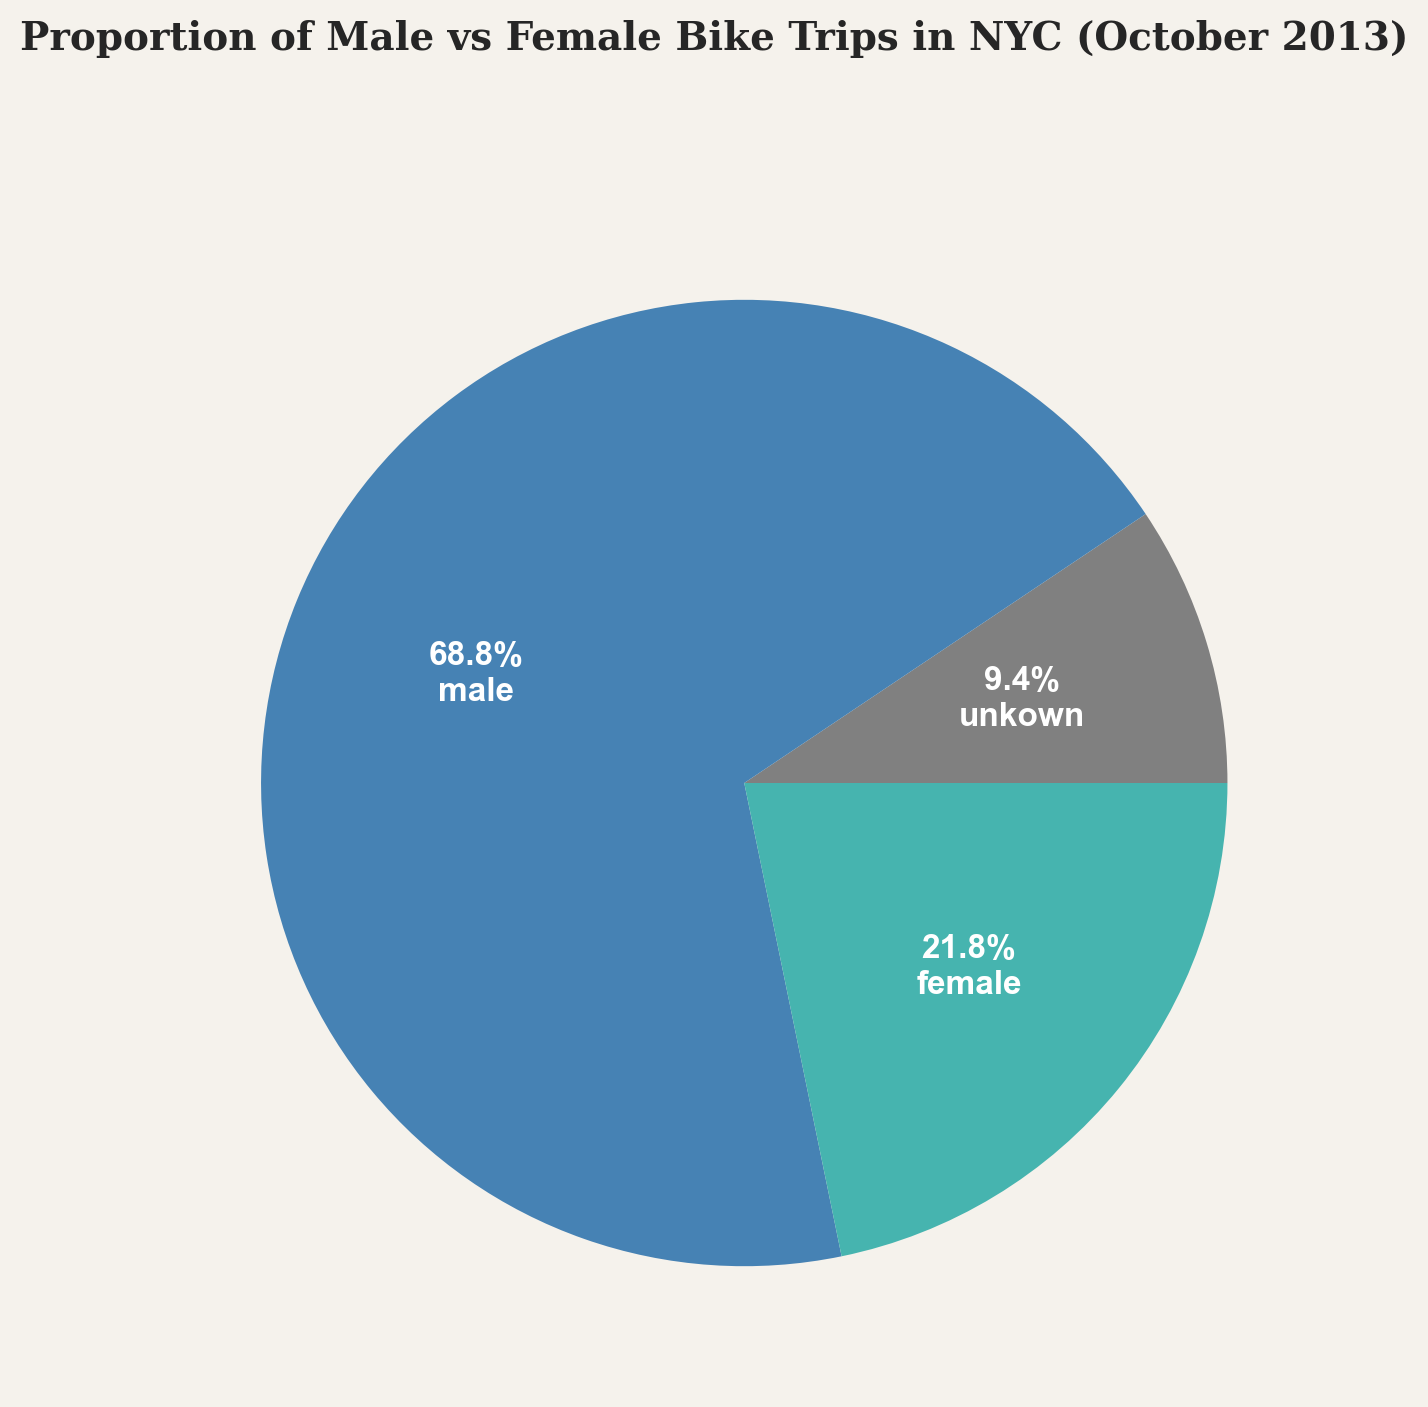

In [13]:
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes()

gendertrips = [x for x in genderdata['bikeid']]
gender = [x for x in genderdata['gender']]

gtdict = dict(zip(gendertrips,gender))
gndict = {0:'unkown',1:'male',2:'female'}
 
# print(rdict)

def func(pct, allvals):
    val = int(np.round(pct/100.*np.sum(allvals)))
    genderkey = gtdict[val]
    gendername = gndict[genderkey]
    return f"{pct:.1f}%\n{gendername}"


wedges, texts, autotexts = ax.pie(gendertrips
                                  , colors=['grey','#4682B4','#46b4af']
                                  , autopct=lambda pct: func(pct, gendertrips)
                                  ,textprops=dict(color="w"))

fig.suptitle("Proportion of Male vs Female Bike Trips in NYC (October 2013)", fontsize=14, fontfamily='serif', weight='bold')
fig.set_facecolor('#f5f2ec')
plt.setp(autotexts, size=12, weight="bold")

plt.show()

#### Analysis for total number of daily trips

In [14]:
# create day's date column
data['daydate'] = data['starttime'].dt.date

In [15]:
# count daily number of trips
dailytrips = data[['daydate','bikeid']].groupby('daydate').count().reset_index()

In [16]:
#  convert days date column to datetime datatype
dailytrips['daydate'] = pd.to_datetime(dailytrips['daydate'])

#### Line Chart

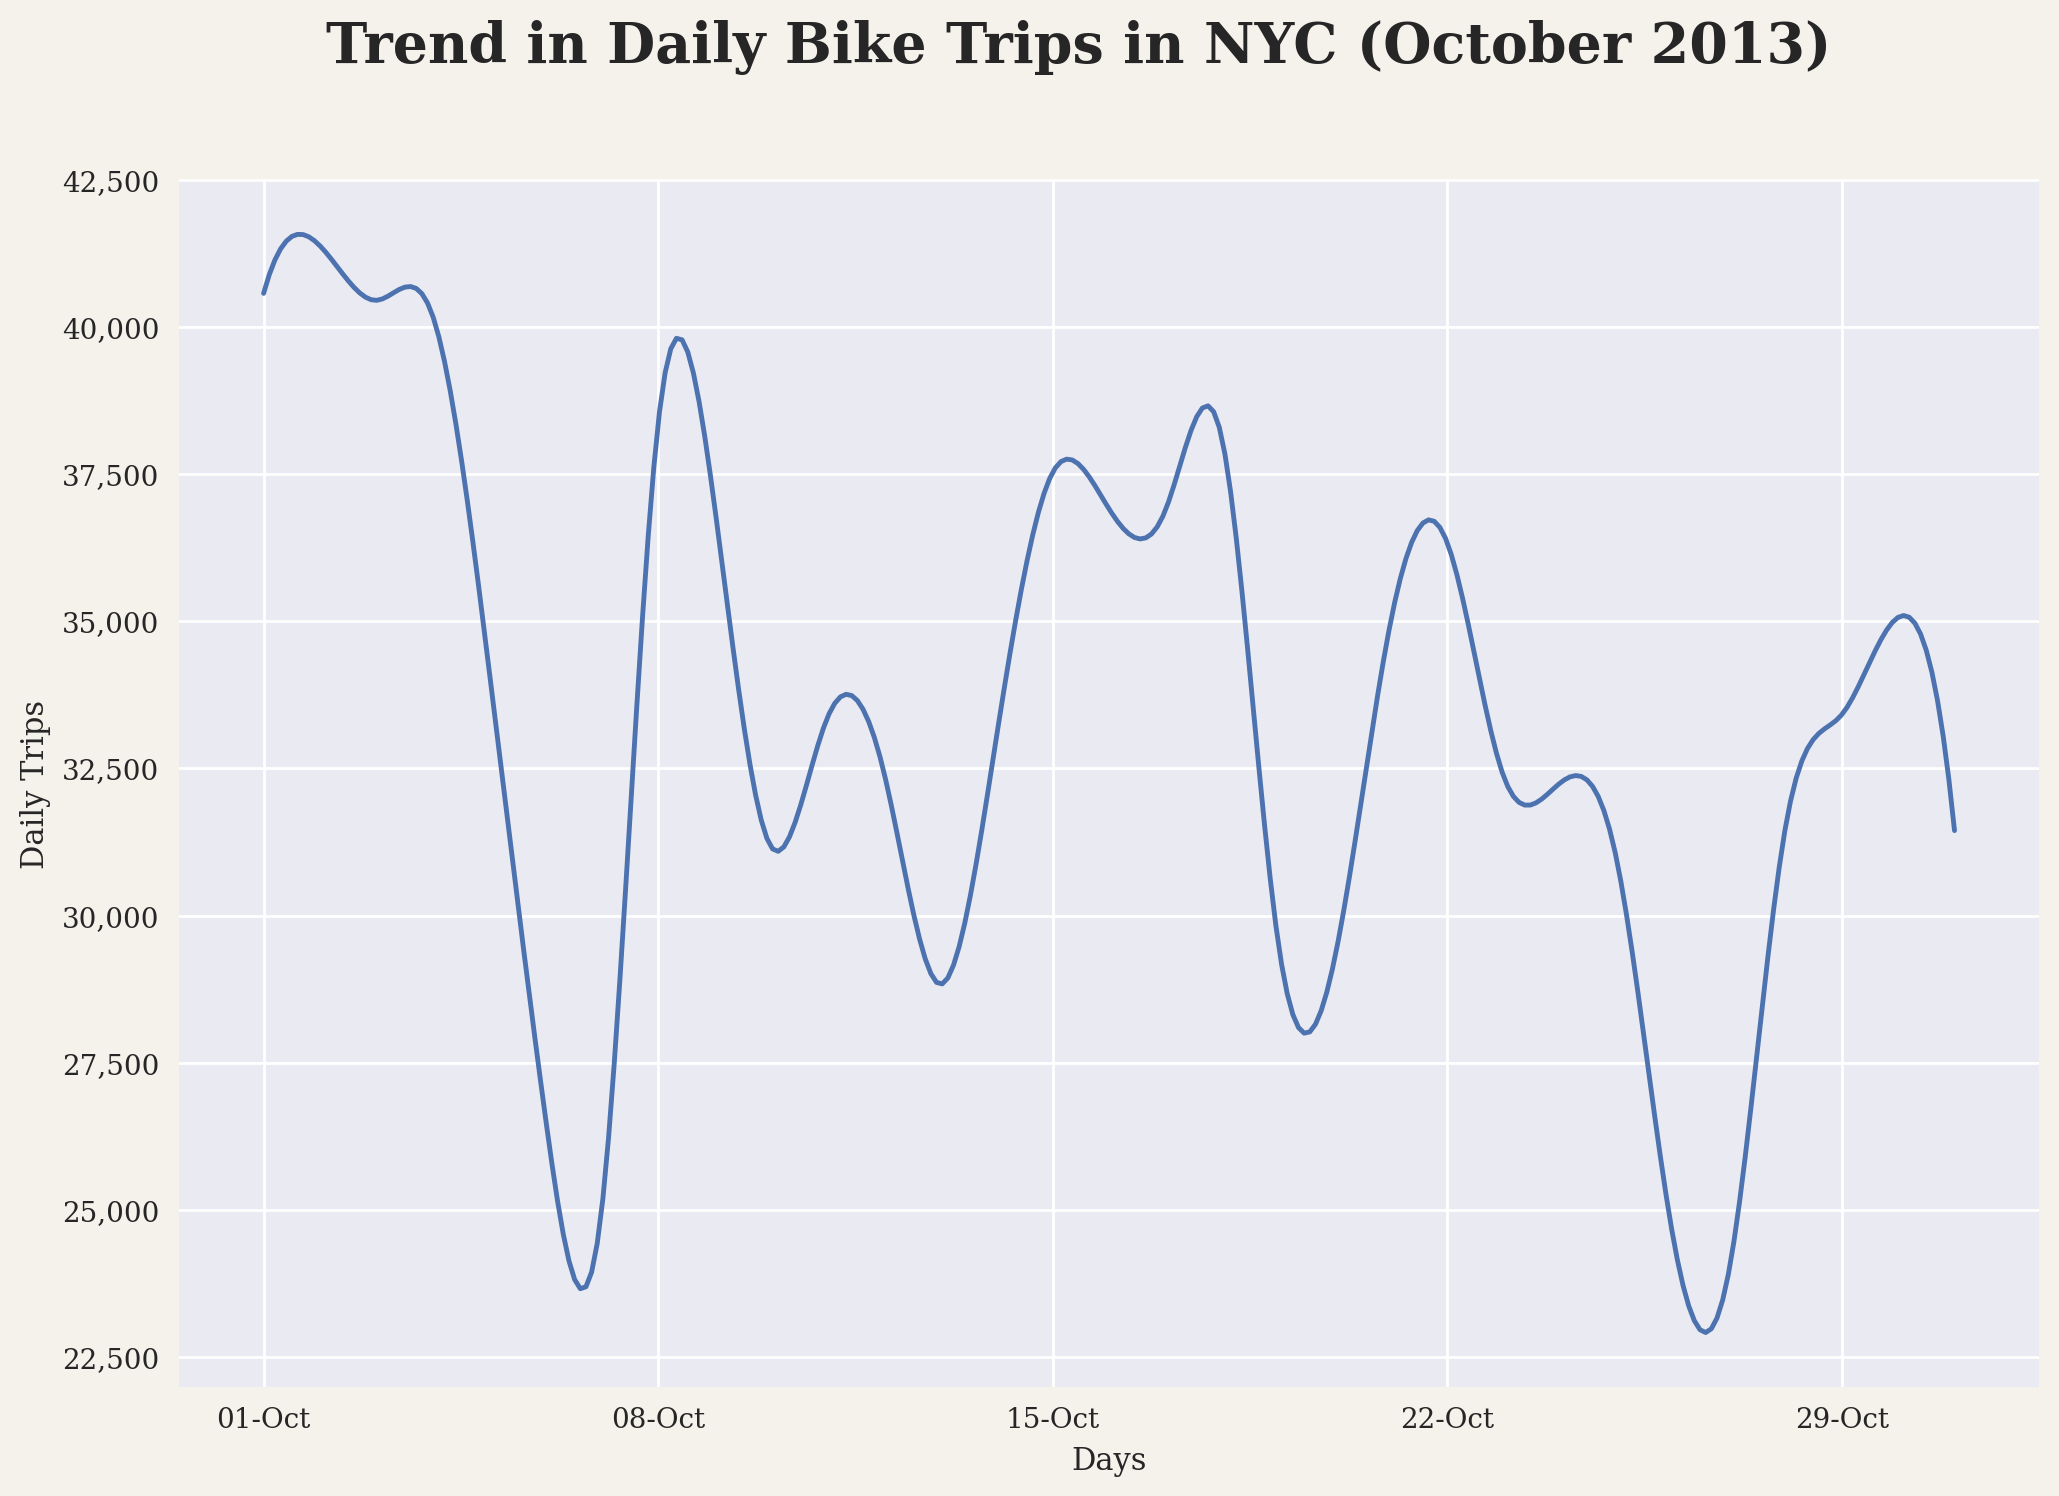

In [17]:
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes()

ddates = dailytrips.daydate
vlaues = dailytrips.bikeid
xnew = pd.date_range(ddates.min(), ddates.max(), periods=300)
spl = make_interp_spline(ddates, vlaues, k=3)  # type: BSpline
smooth = spl(xnew)

plt.plot(xnew, smooth)

fig.suptitle("Trend in Daily Bike Trips in NYC (October 2013)", fontsize=20, fontfamily='serif', weight='bold')
fig.set_facecolor('#f5f2ec')

ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:0,.0f}'))
ax.set_xlabel('Days', fontfamily = 'Serif')
ax.set_ylabel('Daily Trips', fontfamily = 'Serif')
plt.yticks(fontname = 'Serif')
plt.xticks(fontname = 'Serif')


plt.show()


#### Calculating trip distance from longitude and latitude

In [18]:
data['distance'] = data.apply(lambda row: h3.point_dist((row['start station latitude'], row['start station longitude']), (row['end station latitude'], row['end station longitude'])), axis=1)

#### Scatter Plots

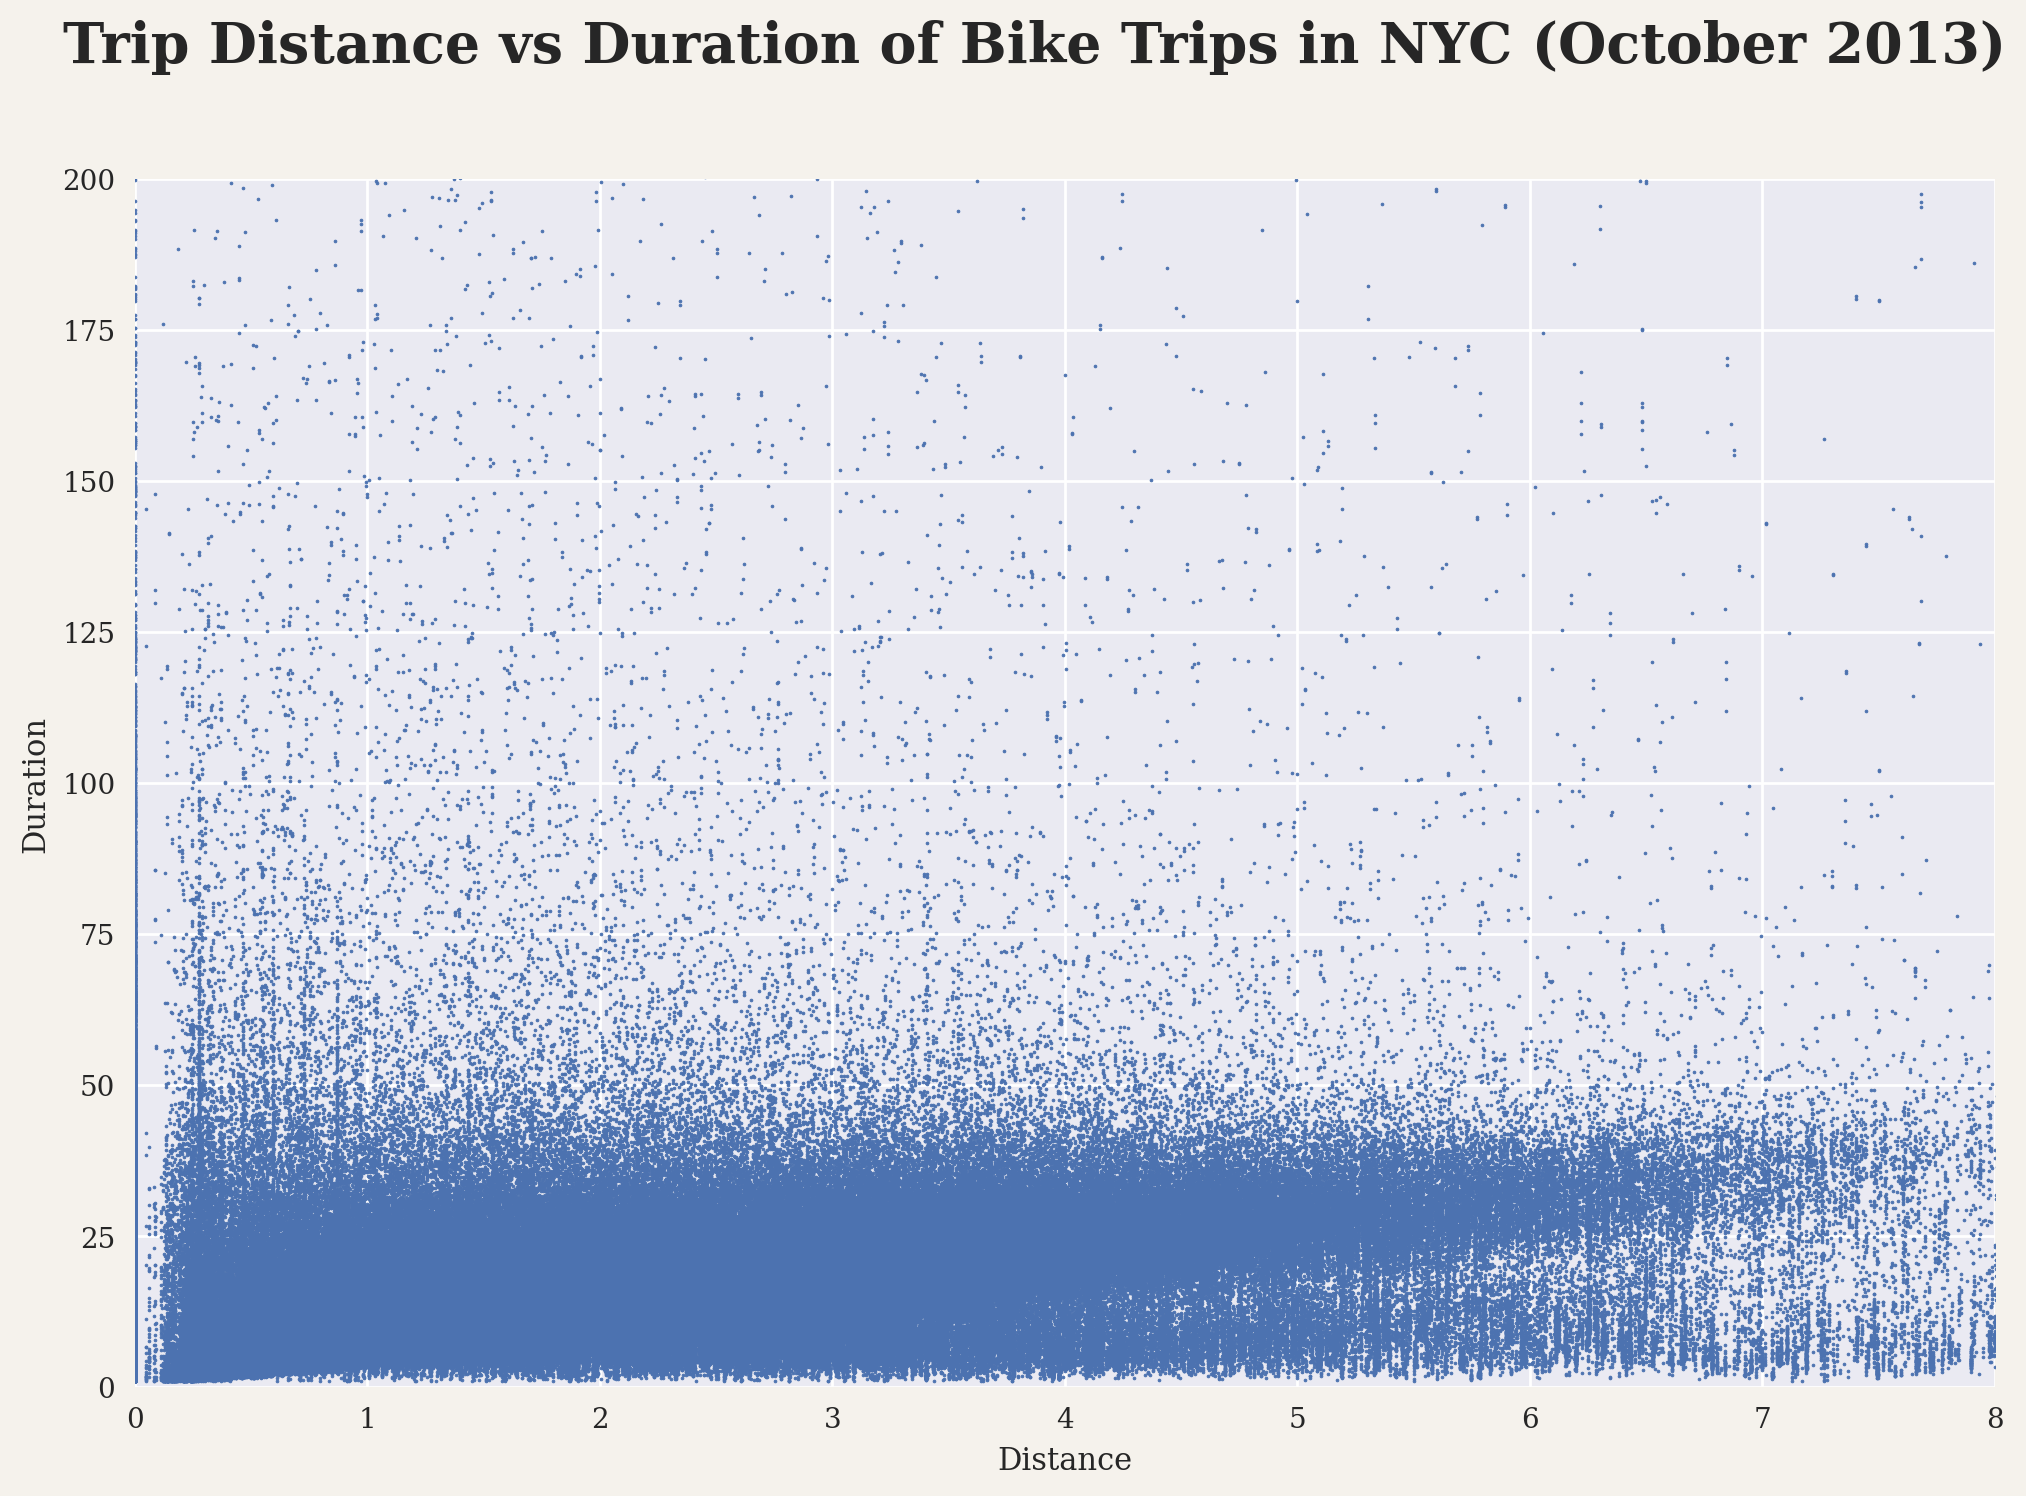

In [19]:
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes()


plt.scatter(data['distance'], data['tripduration']/60, s=1)

fig.suptitle("Trip Distance vs Duration of Bike Trips in NYC (October 2013)", fontsize=20, fontfamily='serif', weight='bold')
fig.set_facecolor('#f5f2ec')

# ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator())
# ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:0,.0f}'))
ax.set_xlabel('Distance', fontfamily = 'Serif')
ax.set_ylabel('Duration', fontfamily = 'Serif')
plt.yticks(fontname = 'Serif')
plt.xticks(fontname = 'Serif')

plt.ylim(0,200)
plt.xlim(0,8)


plt.show()


In [20]:
scatterdata = data[['distance', 'tripduration']].dropna()
scatterdata['tripduration'] = scatterdata['tripduration']/60
scatterdata = scatterdata.loc[(scatterdata['tripduration'] <= 60) & (scatterdata['distance'] >= 0.5)]

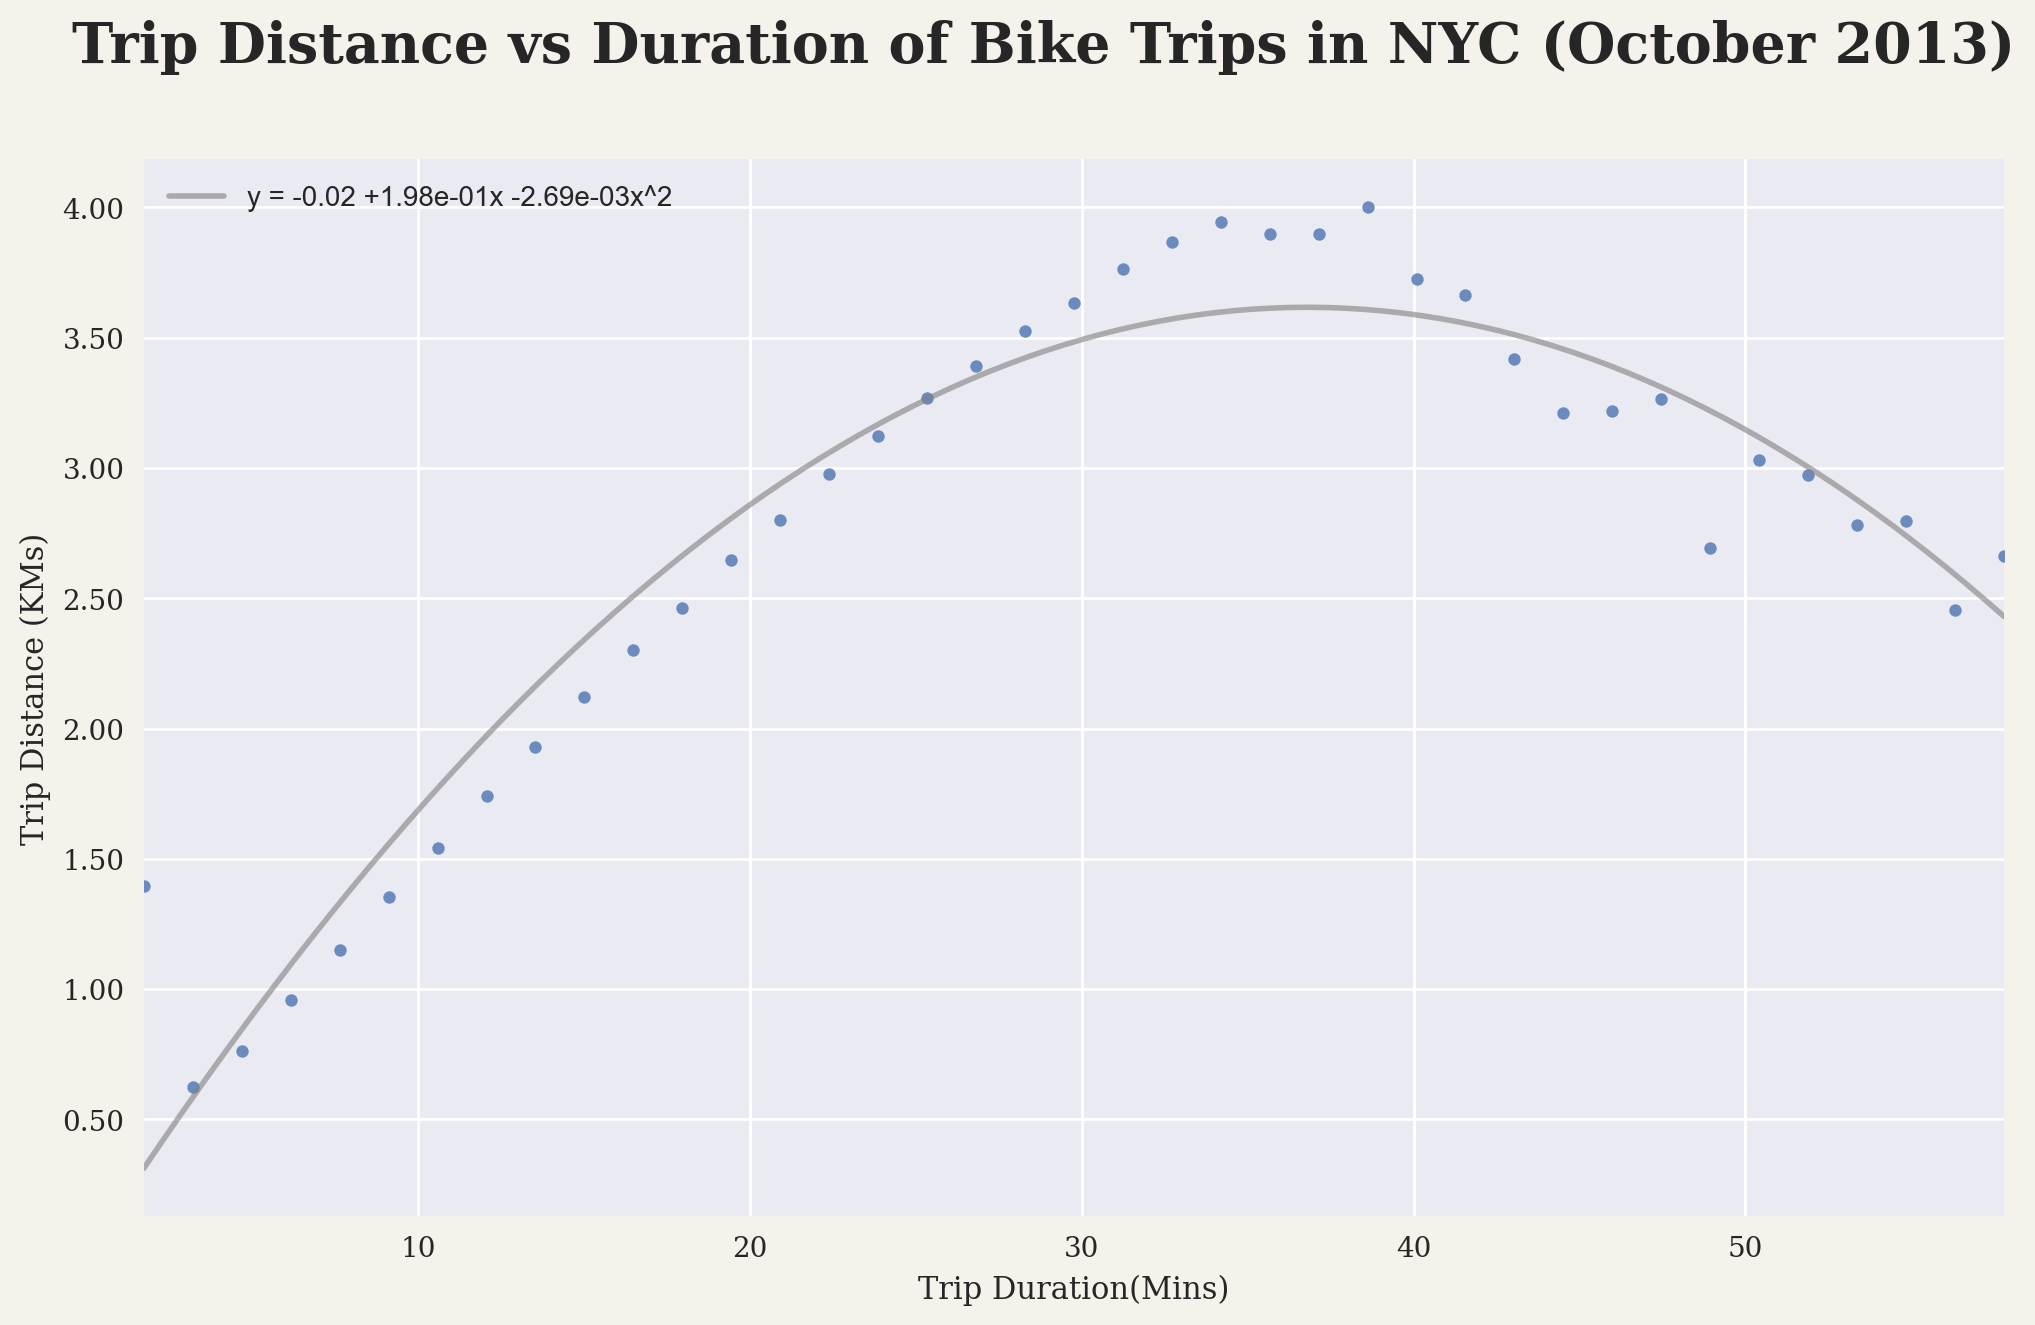

In [21]:
polydeg = 2
values = scatterdata.distance
bin_means, bin_edges, binnumber = stats.binned_statistic(scatterdata.tripduration, values, 'median', bins=40)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X, y = bin_centers[:-1].reshape(-1,1), bin_means[:-1]

poly_reg_transform = PolynomialFeatures(degree=polydeg)
X_poly = poly_reg_transform.fit_transform(X)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly,np.nan_to_num(y))
y_pred_poly = poly_reg_model.predict(X_poly)
intercept = poly_reg_model.intercept_
slopes = poly_reg_model.coef_

fig = plt.figure(figsize=(12,7), dpi=200)
ax = sns.regplot(
    x=X.ravel(), #'takehome',
    y=np.nan_to_num(y).ravel(),  #'cummOut_b',
    data=scatterdata,
    scatter_kws={"s":20},
    order=polydeg,
    ci=None,
    line_kws={
        'color':'grey',
        'alpha':0.6,
        'linewidth':2,
        'label':r'y = {0:.2f} {1:+.2e}x {2:+.2e}x^2'.format(intercept,slopes[1],slopes[2])
    }
)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))
# ax.set_ylim(0,1600)
ax.set_xlim(min(X),max(X))
ax.set_xlabel("Trip Duration(Mins)", fontfamily = 'Serif')
ax.set_ylabel("Trip Distance (KMs)", fontfamily = 'Serif')

fig.suptitle("Trip Distance vs Duration of Bike Trips in NYC (October 2013)", fontsize=20, fontfamily='serif', weight='bold')
fig.set_facecolor('#f5f2ec')

plt.yticks(fontname = 'Serif')
plt.xticks(fontname = 'Serif')

plt.legend(loc="upper left")
plt.show()

#### Heatmap Chart

In [22]:
glue = sns.load_dataset("glue").pivot("Model", "Task", "Score")

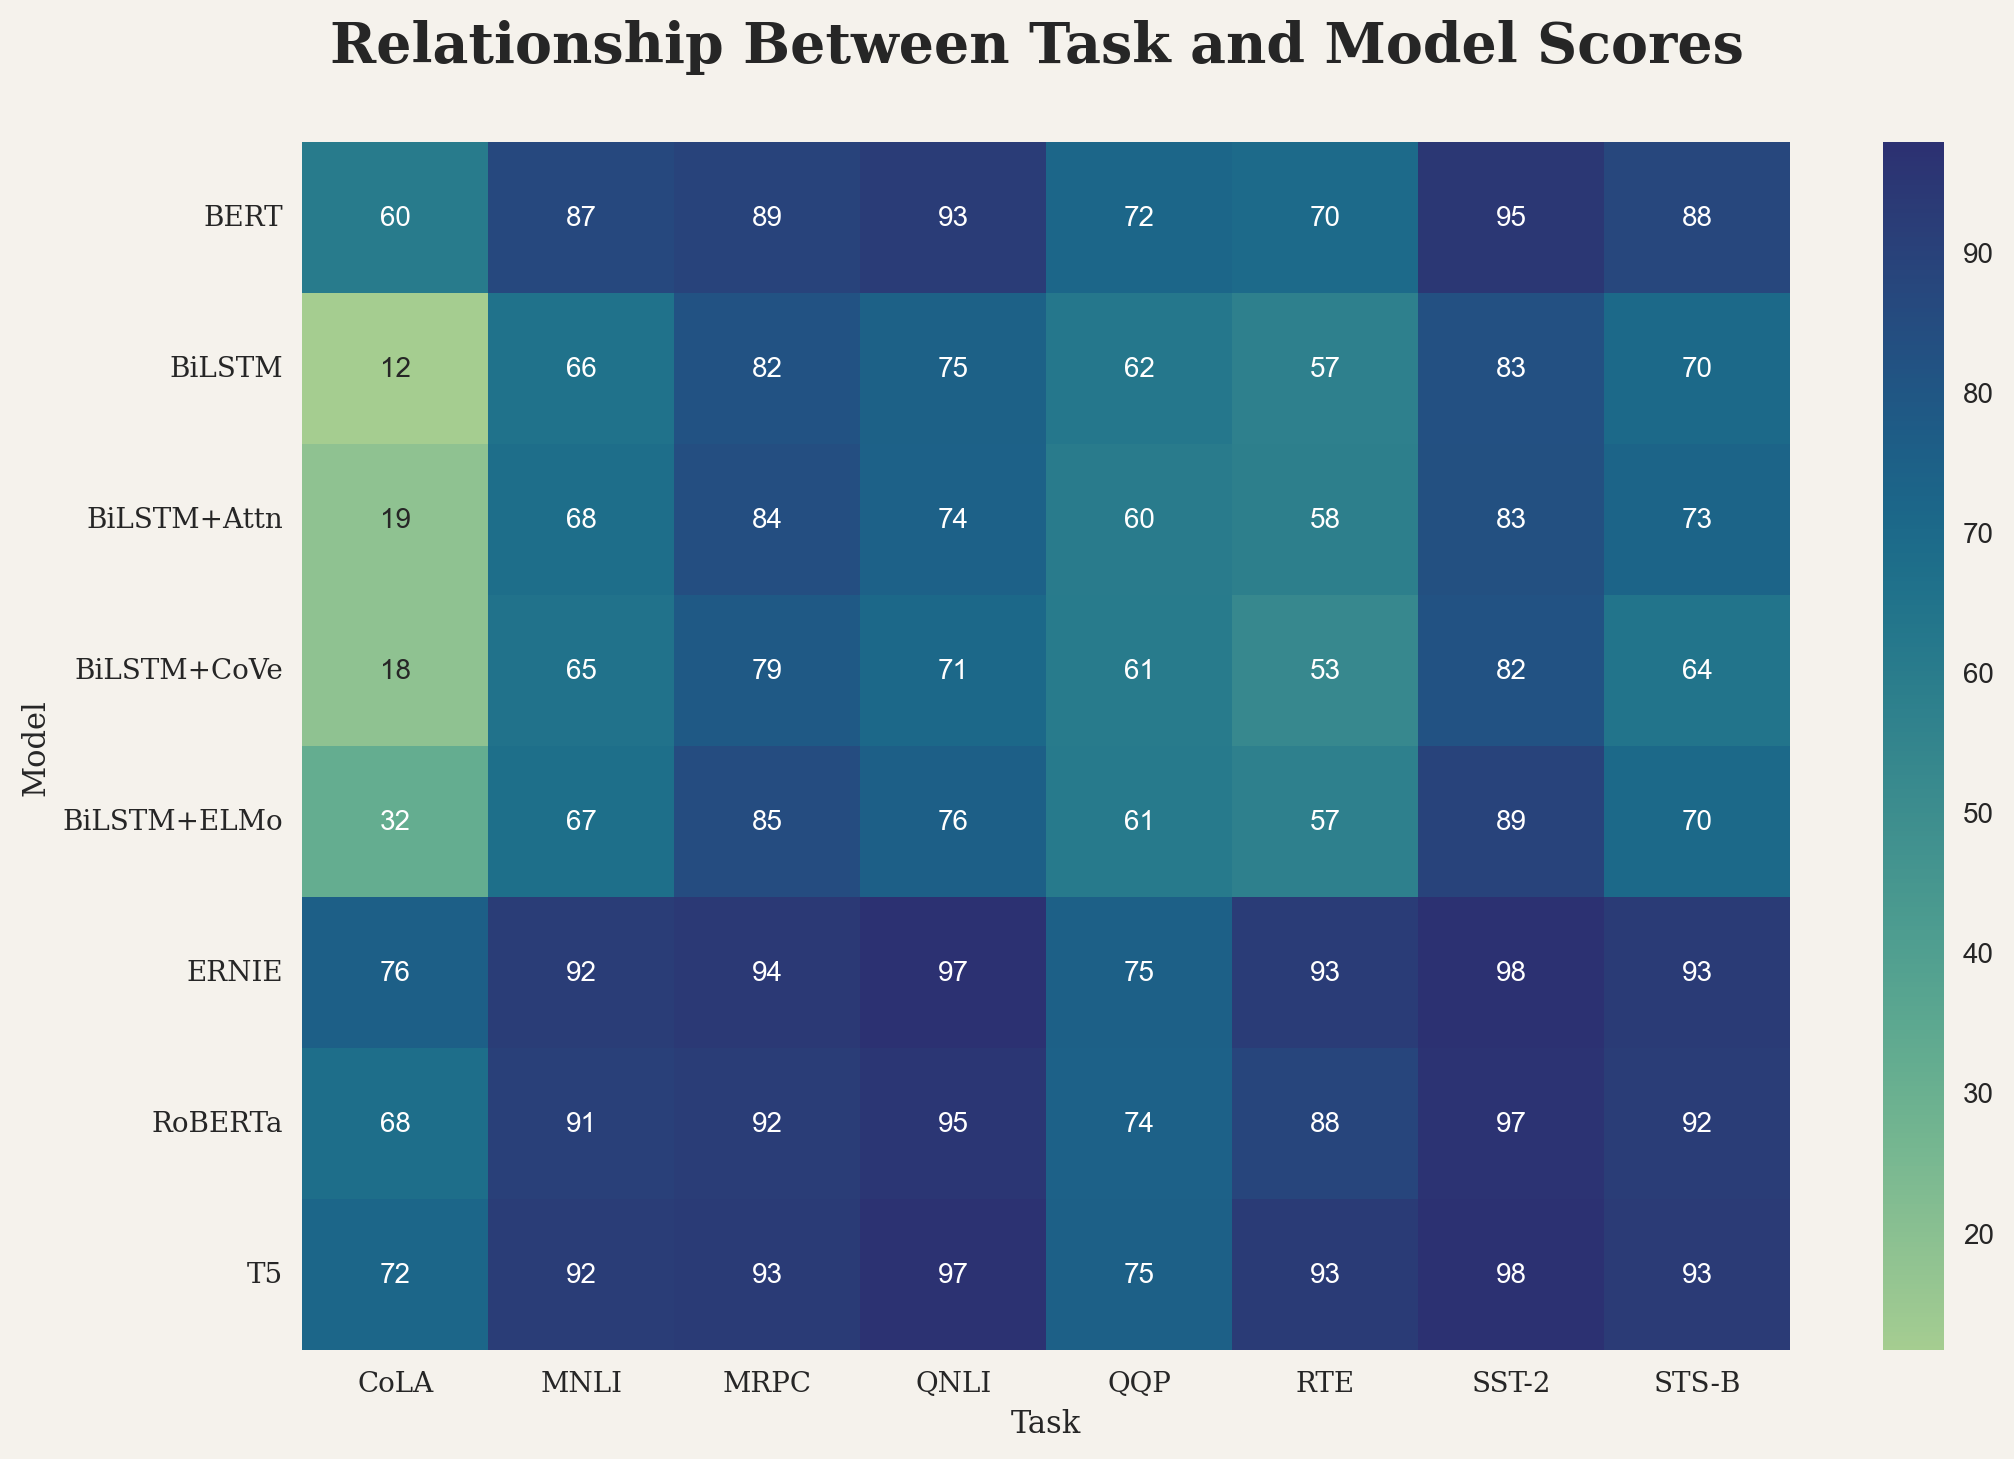

In [23]:
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes()

sns.heatmap(glue, cmap="crest", annot=True, ax=ax)

plt.title("Relationship Between Task and Model Scores \n ", fontsize=20, fontfamily='serif', weight='bold')
fig.set_facecolor('#f5f2ec')

ax.set_xlabel('Task', fontfamily = 'Serif')
ax.set_ylabel('Model', fontfamily = 'Serif')
plt.yticks(fontname = 'Serif')
plt.xticks(fontname = 'Serif')


plt.show()


#### Box Plot

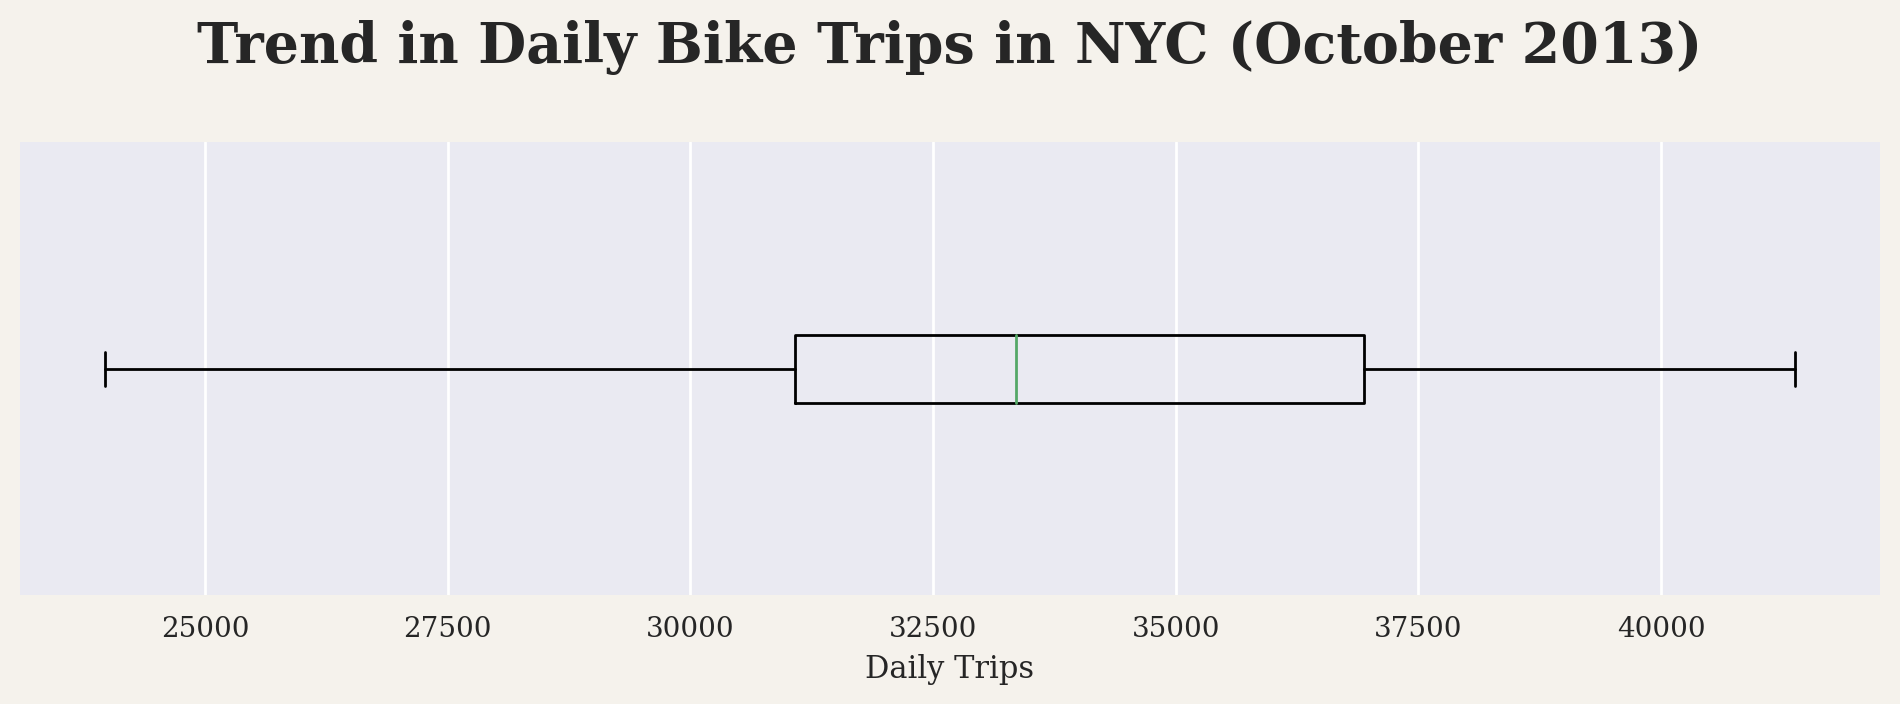

In [24]:
fig = plt.figure(figsize=(12,3), dpi=200)
ax = plt.axes()


plt.boxplot(dailytrips.bikeid, vert=False)

plt.title("Trend in Daily Bike Trips in NYC (October 2013)\n", fontsize=20, fontfamily='serif', weight='bold')
fig.set_facecolor('#f5f2ec')

ax.set_xlabel('Daily Trips', fontfamily = 'Serif')
ax.axes.get_yaxis().set_visible(False)
plt.xticks(fontname = 'Serif')


plt.show()
